# Pre-processing
## this code takes the original lif file and preps it for inference on the nnU-net trained model 
all it does it convert the lif file into nrrd with ethe scale as header 
then it extract the green channel only 



## to transfer lif to hpc:

scp -r "/Volumes/Salem HD/Salem 63x Chip images/Pretty chips for pub 28-1-25 H+N, H+M.lif" dj724@login.hpc.ic.ac.uk:/rds/general/user/dj724/home/msc-project/lif_files

In [1]:
# Load modules 
import os 
import numpy as np
from readlif.reader import LifFile
import nrrd
import matplotlib.pyplot as plt

In [2]:
# Paths and filenames
lif_path = "  " #path to the lif file 
lif_file_name = " " #name of file for organisation purposes
output_folder = " " #location to store the image for inference
os.makedirs(output_folder, exist_ok=True) # if the output folder does not exist then create it

# Select the image number in the lif file stack
image_nr_in_stack = 4
i = image_nr_in_stack -1 #make sure it is in python numbering which starts from 0

case_identifier = "Vessels#" #choose any

In [3]:
# Load LIF file and specific image
lif = LifFile(lif_path)
lif_image = lif.get_image(i)  # 0-indexed

# Retrieve the dimensions of the selected image
# 'Z' represents the number of Z-slices (depth).
# 'C' represents the number of channels (colours).
Z = lif_image.dims.z
C = lif_image.channels
print(f"Z slices: {Z}, Channels: {C}")

# Load full stack into shape (Z, C, Y, X)
image = np.stack([ #concatenates Z-slices
    np.stack([ #concatenates channels
        np.array(lif_image.get_frame(z=z, c=c)) #retrieves a single 2D frame.
        for c in range(C)
    ], axis=0)
    for z in range(Z)
], axis=0)

print("Image shape:", image.shape)  # Expect (Z, C, Y, X)

Z slices: 116, Channels: 3
Image shape: (116, 3, 1051, 1932)


In [4]:
# get spacing infromation of the image
scale_um = list(lif_image.scale[:3])  # [x_scale, y_scale, z_scale] in µm
scale_mm = [s / 1000 for s in scale_um]  # mm
spacing_mm = [1/s for s in scale_mm]
# you are supposed to use scale um instead of spacing. this is preprocessing and will be adjusted for during post-processing
print("Voxel scale (um):", scale_um)
print("Voxel scale (mm):", scale_mm)

Voxel scale (um): [4.158000576650727, 4.15800086486418, 2.0061993303829992]
Voxel scale (mm): [0.0041580005766507265, 0.00415800086486418, 0.0020061993303829993]


In [5]:
# Save each channel to NRRD in (X, Y, Z) format
for c in range(C):
    channel_data = image[:, c, :, :]  # shape: (Z, Y, X)
    
    # Transpose from (Z, Y, X) → (X, Y, Z)
    channel_data_xyz = np.transpose(channel_data, (2, 1, 0))  # Now (X, Y, Z)
    print(f"Channel {c} transposed shape:", channel_data_xyz.shape)

    # Define NRRD header
    header = {
        'space': 'left-posterior-superior',  # default used by Slicer (RAS)
        'space directions': [
            [scale_mm[0], 0.0, 0.0],  # X
            [0.0, scale_mm[1], 0.0],  # Y
            [0.0, 0.0, scale_mm[2]]   # Z
        ],
        'kinds': ['domain', 'domain', 'domain'],
        'encoding': 'raw',
        'type': 'float' if channel_data_xyz.dtype in [np.float32, np.float64] else 'uint8'
    }

    filename = f"{case_identifier}_{c:04d}.nrrd"
    filepath = os.path.join(output_folder, filename)
    nrrd.write(filepath, channel_data_xyz, header)
    print(f"Saved: {filepath}")
    
# The images need to have scale mm as spacing and not spacing due to mistakes during training. this does not impact the inference performance!
print("All NRRD files saved with SCALE! and orientation")

Channel 0 transposed shape: (1932, 1051, 116)
Saved: /rds/general/user/dj724/home/msc-project/Output_files_step1test/testforben_0000.nrrd
Channel 1 transposed shape: (1932, 1051, 116)
Saved: /rds/general/user/dj724/home/msc-project/Output_files_step1test/testforben_0001.nrrd
Channel 2 transposed shape: (1932, 1051, 116)
Saved: /rds/general/user/dj724/home/msc-project/Output_files_step1test/testforben_0002.nrrd
All NRRD files saved with SCALE! and orientation


Preprocessing is completed. The codes below are for test purposes only to make sure that everything has been uploaded properly and also to check which channel belong to the proper staing channel wich should be staining the vessel membrane with WGA

Shape: (1932, 1051, 116)


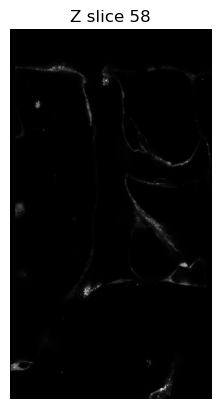

In [8]:
#Check the midle z-slice in the image to confirm that the image is correct for further inference
# If you are not sure which of the channels belong to the correct one, you check each of the images

#here the 2nd channel, indicated by 0002 was the green channel. 
data, header = nrrd.read("/rds/general/user/dj724/home/msc-project/Output_files_step1test/testforben_0002.nrrd")

print("Shape:", data.shape)

# Show middle Z-slice
middle_z = data.shape[2] // 2
plt.imshow(data[:, :, middle_z], cmap='gray')
plt.title(f"Z slice {middle_z}")
plt.axis('off')
plt.show()

In [23]:
#check that the spacing is actuallt scale!
print(header['space directions'])


[[0.004158  0.        0.       ]
 [0.        0.004158  0.       ]
 [0.        0.        0.0020062]]
